In [ ]:
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler

In [ ]:
from sklearn.datasets import make_blobs
n_samples_1 = 1000
n_samples_2 = 100
centers = [[0.0, 0.0], [2.0, 2.0]]
clusters_std = [1.5 , 0.5]
X, y = make_blobs( n_samples=[n_samples_1 , n_samples_2 ],
centers=centers,
cluster_std=clusters_std,
random_state=0, shuffle=False)

In [ ]:
def truncate(f, n):
    '''Truncates/pads a float f to n decimal places without rounding'''
    s = '{}'.format(f)
    if 'e' in s or 'E' in s:
        return '{0:.{1}f}'.format(f, n)
    i, p, d = s.partition('.')
    return '.'.join([i, (d+'0'*n)[:n]])



**Візуалізуємо отримані дані**

Як видно з візуалзізації, дані розбиті на два класи що пересікаються, і, в загальному випадку, не є роздільними



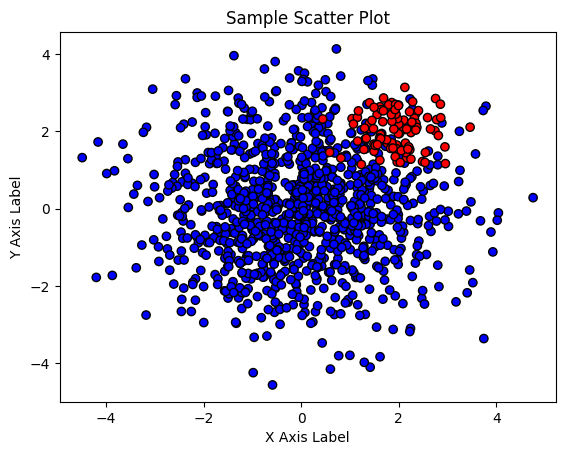

In [ ]:
colors = ['red' if i & 1 else 'blue' for i in y]
plt.scatter(X[:, 0], X[:, 1], c=colors, edgecolor='black', linewidths=1)
plt.title("Sample Scatter Plot")
plt.xlabel("X Axis Label")
plt.ylabel("Y Axis Label")
plt.show()

**Виконаємо навчання моделі з емпіричними параметрами**

Оскільки датасет є незбалансованим, то при навчанні моделі використовується параметр class_weight='balanced'

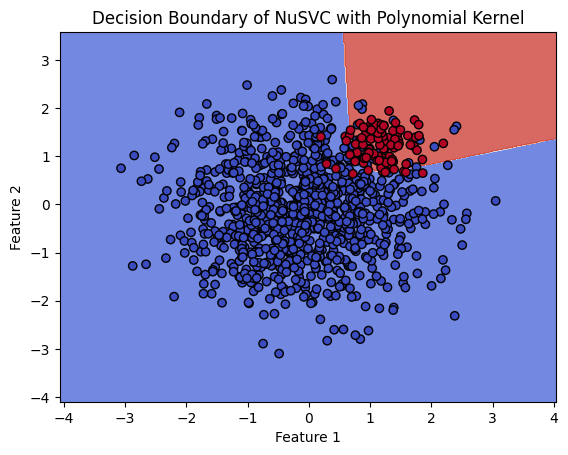

In [ ]:
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Train a NuSVC model with a polynomial kernel
model = MLPClassifier(random_state=42, max_iter=300, hidden_layer_sizes=(20, 10, 5))
model.fit(X, y)
# model.fit(X, y, sample_weight=weights)


# Create a mesh grid to plot decision boundaries
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02), np.arange(y_min, y_max, 0.02))

# Predict over the grid
Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

# Plot decision boundary
plt.contourf(xx, yy, Z, alpha=0.8, cmap=plt.cm.coolwarm)
plt.scatter(X[:, 0], X[:, 1], c=y, edgecolors='k', marker='o', cmap=plt.cm.coolwarm)
plt.title("Decision Boundary of NuSVC with Polynomial Kernel")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.show()

Візуалізуємо як веде себе модель для різних параметрів nu, degree, coef0

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to cont

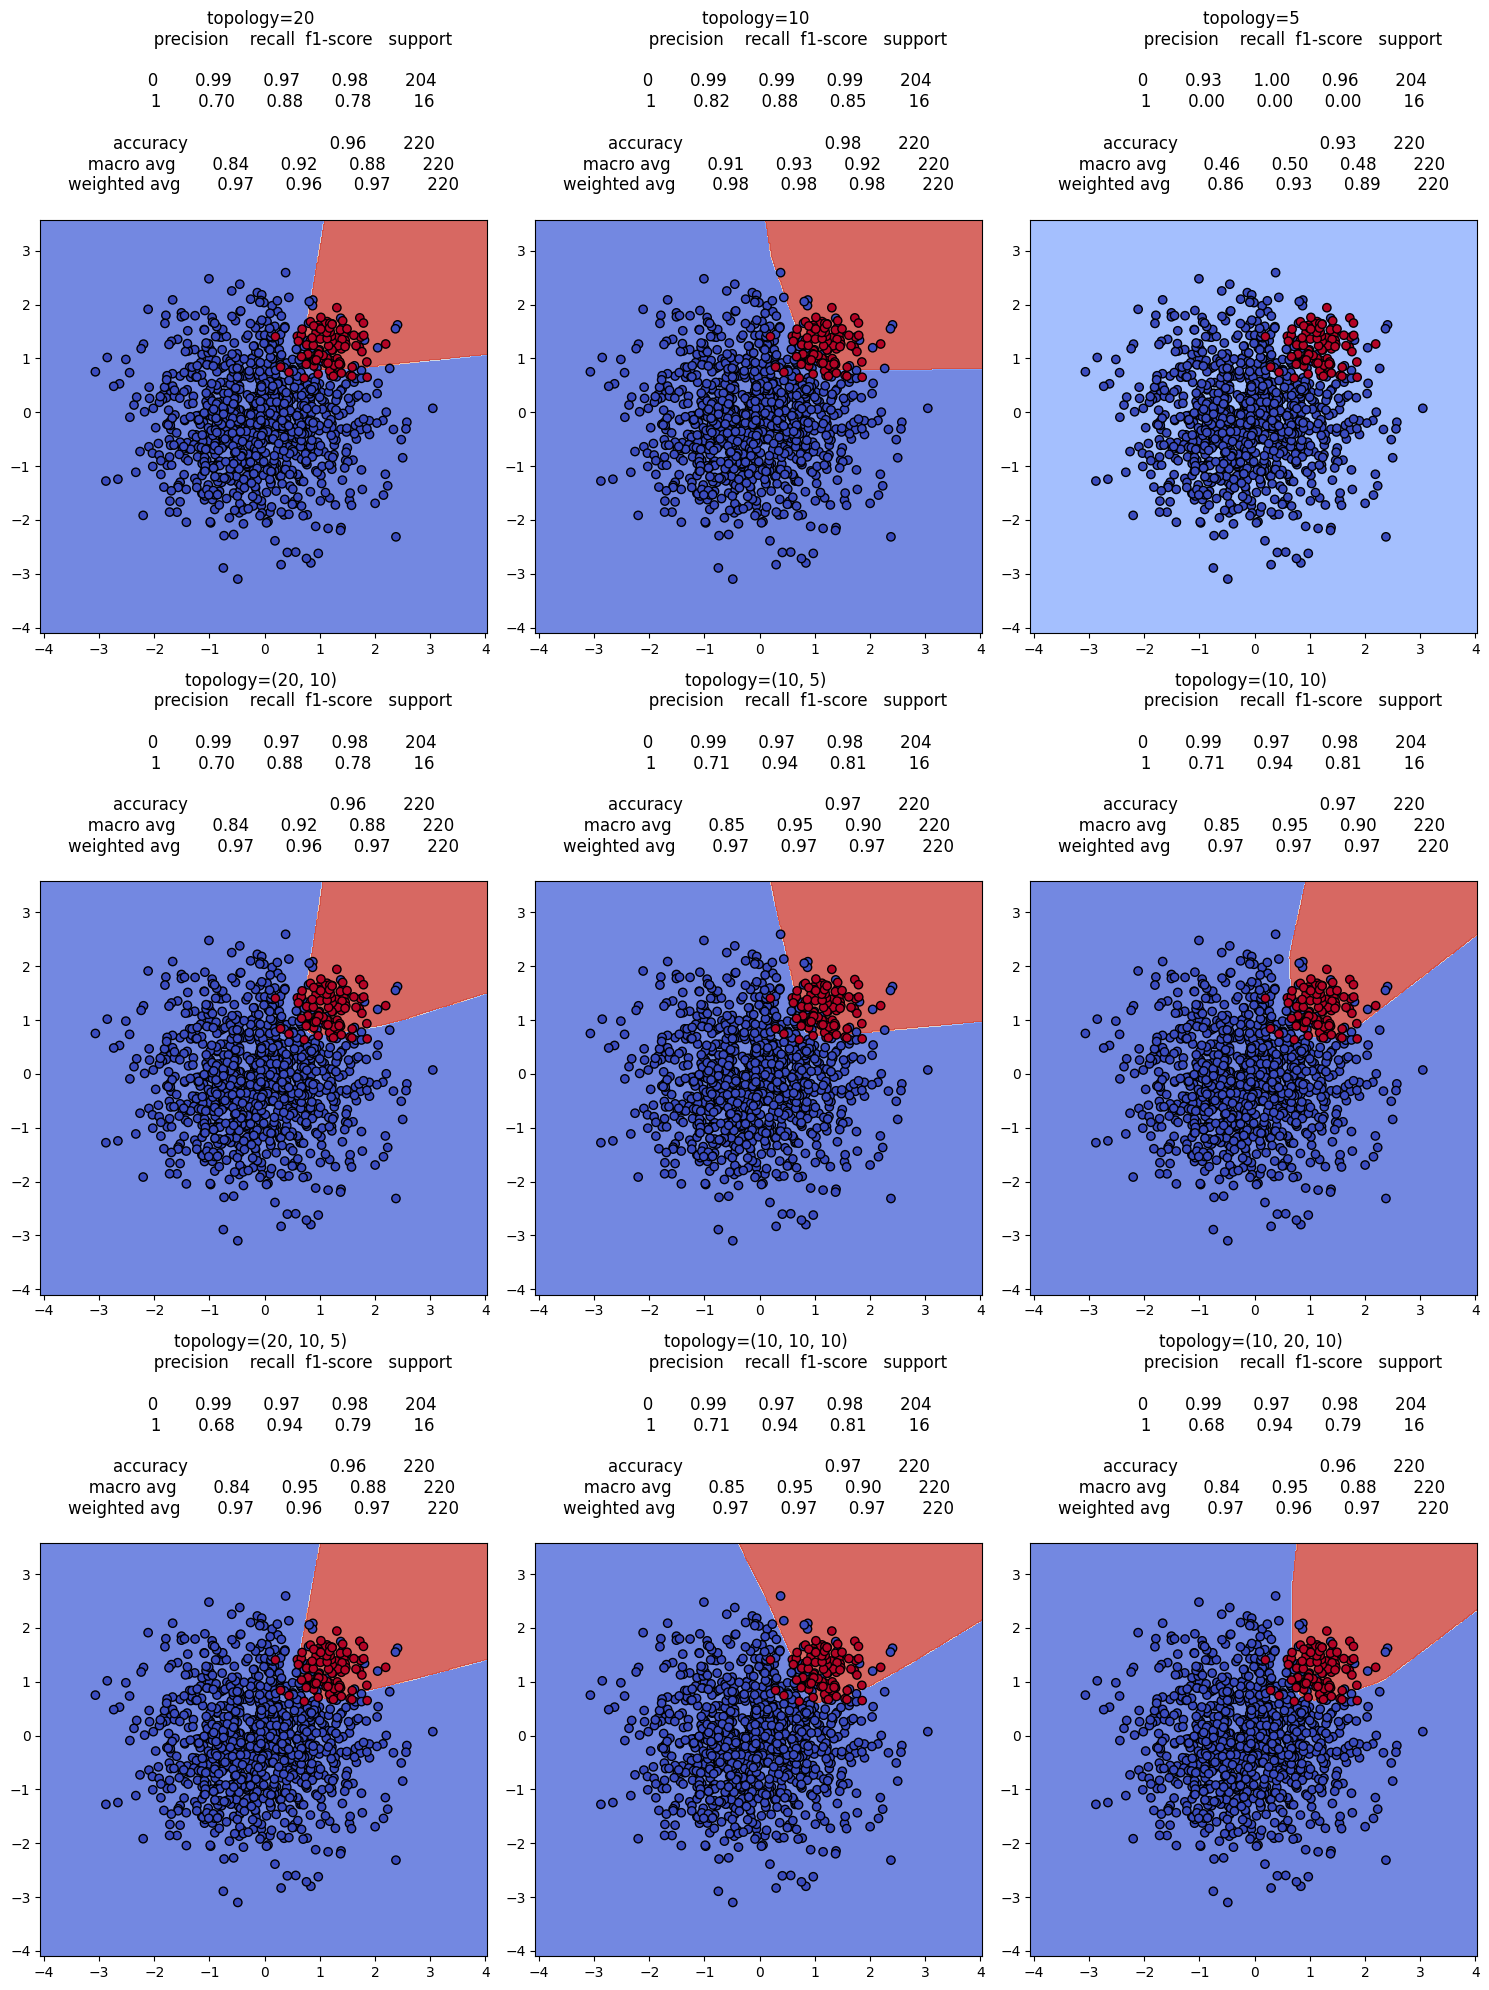

In [ ]:
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import classification_report, confusion_matrix, multilabel_confusion_matrix, f1_score
import itertools

x = np.linspace(0, 10, 100)
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 20))


params = [
    (20),
    (10),
    (5),
    (20, 10),
    (10, 5),
    (10, 10),
    (20, 10, 5),
    (10, 10, 10),
    (10, 20, 10)
]

axes = axes.flatten()

for ax, param in zip( axes, params ):
  # degree, nu, coef = param

  X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

  model = MLPClassifier(random_state=42, max_iter=300, hidden_layer_sizes=param)
  model.fit(X_train, y_train)

  weights =  np.array( map(lambda x: 1 if x == 0 else 10, [*y_test]) )

  y_pred = model.predict(X_test)
  report = classification_report(y_test, y_pred)


  x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
  y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
  xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02), np.arange(y_min, y_max, 0.02))

  Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
  Z = Z.reshape(xx.shape)

  score = model.score(X, y)
  score = truncate(score, 3)

  ax.contourf(xx, yy, Z, alpha=0.8, cmap=plt.cm.coolwarm)
  ax.scatter(X[:, 0], X[:, 1], c=y, edgecolors='k', marker='o', cmap=plt.cm.coolwarm)
  ax.set_title(f"""topology={param} \n {str(report)}""")

plt.tight_layout()
plt.show()


Знайдемо мінімальну модель з одним прихованим шаром, яка буде задовільняти цільовий параметр (f1-score) - 0.95.

In [ ]:
def find_min_neurons(X_train, X_test, y_train, y_test, score=f1_score, min_score=0.95, max_neurons=40, weights=None):
  for n in range(1, max_neurons+1):
    model = MLPClassifier(random_state=42, hidden_layer_sizes=(n), max_iter=300)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    if score(y_test, y_pred, sample_weight=weights) > min_score:
      return model, n
  raise Exception("This model cannot provide designated accuracy")

In [ ]:
y_train.shape

(880,)

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


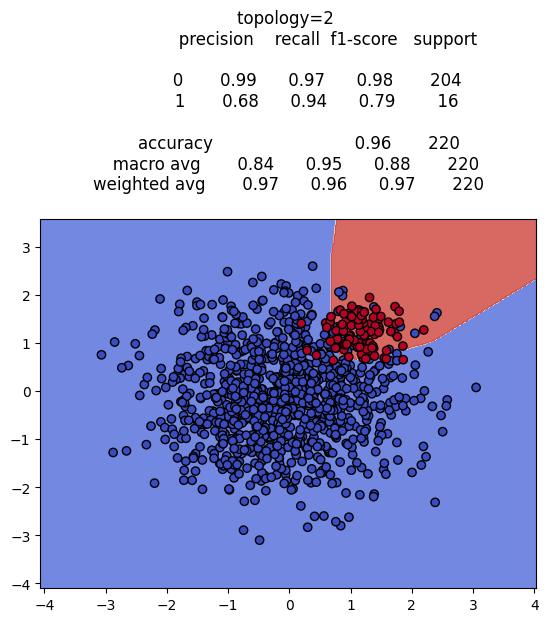

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
weights =  list( map(lambda x: 1 if x == 0 else 10, [*y_test]) )
smallest_model, min_neurons = find_min_neurons(X_train, X_test, y_train, y_test, min_score=0.95, weights=weights)
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02), np.arange(y_min, y_max, 0.02))

Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

score = model.score(X, y)
score = truncate(score, 3)

plt.contourf(xx, yy, Z, alpha=0.8, cmap=plt.cm.coolwarm)
plt.scatter(X[:, 0], X[:, 1], c=y, edgecolors='k', marker='o', cmap=plt.cm.coolwarm)
plt.title(f"""topology={(min_neurons)} \n {str(report)}""")
plt.show()

Виконаємо випадковий пошук оптимальних гіперпараметрів моделі

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import MLPClassifier
from sklearn.datasets import make_classification
from sklearn.pipeline import Pipeline
from sklearn.metrics import make_scorer, f1_score

param_grid = {
    'mlpclassifier__hidden_layer_sizes': [
      (20),
      (10),
      (5),
      (20, 10),
      (10, 5),
      (10, 10),
      (20, 10, 5),
      (10, 10, 10),
      (10, 20, 10)
    ],
    'mlpclassifier__activation': ['relu', 'tanh', 'logistic'],
    'mlpclassifier__solver': ['adam'],
    'mlpclassifier__learning_rate': ['adaptive'],
    'mlpclassifier__max_iter': [200],
}

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=52)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=52)

In [ ]:
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('mlpclassifier', MLPClassifier())
])

f1_scorer = make_scorer(f1_score)
grid_search = GridSearchCV(pipeline, param_grid, cv=5, n_jobs=-1, scoring=f1_scorer)

grid_search.fit(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('mlpclassifier', MLPClassifier())]),
             n_jobs=-1,
             param_grid={'mlpclassifier__activation': ['relu', 'tanh',
                                                       'logistic'],
                         'mlpclassifier__hidden_layer_sizes': [20, 10, 5,
                                                               (20, 10),
                                                               (10, 5),
                                                               (10, 10),
                                                               (20, 10, 5),
                                                               (10, 10, 10),
                                                               (10, 20, 10)],
                         'mlpclassifier__learning_rate': ['adaptive'],
                         'mlpclassifier__max_iter': [200],
                         'mlpclassifier__solver': ['adam']},
             scoring=make_scorer(f1_score, response_method='predict'))

In [ ]:
best_params_rand = grid_search.best_params_
best_params_rand
# best_model_rand = randomized_search.best_estimator_

{'mlpclassifier__activation': 'relu',
 'mlpclassifier__hidden_layer_sizes': (10, 20, 10),
 'mlpclassifier__learning_rate': 'adaptive',
 'mlpclassifier__max_iter': 200,
 'mlpclassifier__solver': 'adam'}

Візуалізуємо найкращу знайдену модель



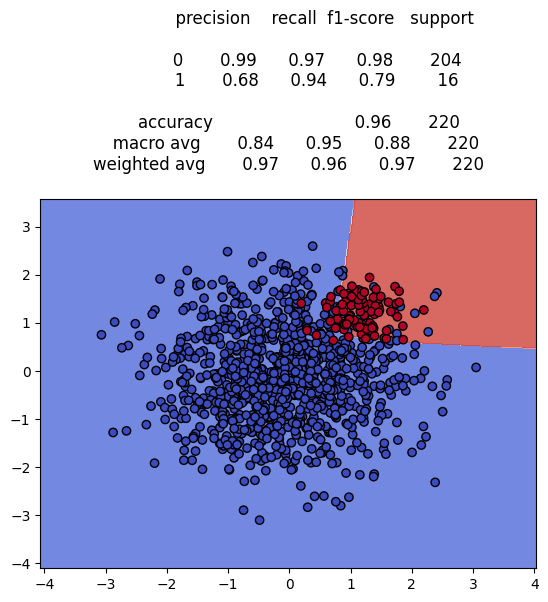

In [ ]:
Z = grid_search.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

score = grid_search.score(X, y)
score = truncate(score, 3)

plt.contourf(xx, yy, Z, alpha=0.8, cmap=plt.cm.coolwarm)
plt.scatter(X[:, 0], X[:, 1], c=y, edgecolors='k', marker='o', cmap=plt.cm.coolwarm)
plt.title(f"""{str(report)}""")

plt.show()

In [ ]:
y_pred = grid_search.predict(X_test)
confusion_matrix(y_test, y_pred)

array([[197,   5],
       [  5,  13]])

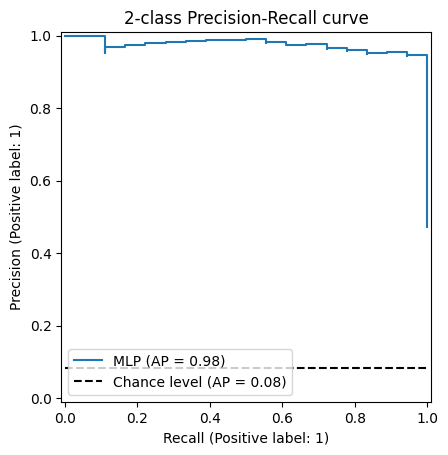

In [ ]:
from sklearn.metrics import PrecisionRecallDisplay, precision_recall_curve

display = PrecisionRecallDisplay.from_estimator(
    grid_search, X_test, y_test, name="MLP", plot_chance_level=True, sample_weight=list( map( lambda x: 10 if x == 1 else 1, y_test ) )
)
_ = display.ax_.set_title("2-class Precision-Recall curve")
# pr_display = PrecisionRecallDisplay(precision=prec, recall=recall).plot()

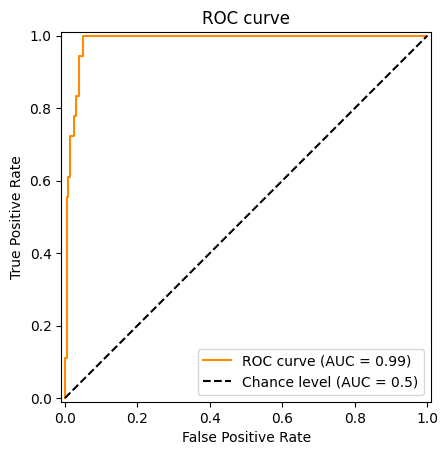

In [ ]:
from sklearn.metrics import roc_curve, RocCurveDisplay

display = RocCurveDisplay.from_estimator(
    grid_search, X_test, y_test,
    name="ROC curve",
    color="darkorange",
    plot_chance_level=True,
    sample_weight=list( map( lambda x: 10 if x == 1 else 1, y_test ) )
)
_ = display.ax_.set(
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
    title="ROC curve",
)
# roc_curve(y_test, y_score[:, 0])

In [ ]:
from sklearn.datasets import load_wine
import pandas as pd
df = load_wine(as_frame=True)
X, y = load_wine(return_X_y=True)
X.shape

(178, 13)

In [ ]:
df = pd.DataFrame(data=np.c_[df['data'], df['target']],
                     columns= df['feature_names'] + ['target'])

In [ ]:
df

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline,target
0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0,0.0
1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0,0.0
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0,0.0
3,14.37,1.95,2.50,16.8,113.0,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480.0,0.0
4,13.24,2.59,2.87,21.0,118.0,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
173,13.71,5.65,2.45,20.5,95.0,1.68,0.61,0.52,1.06,7.70,0.64,1.74,740.0,2.0
174,13.40,3.91,2.48,23.0,102.0,1.80,0.75,0.43,1.41,7.30,0.70,1.56,750.0,2.0
175,13.27,4.28,2.26,20.0,120.0,1.59,0.69,0.43,1.35,10.20,0.59,1.56,835.0,2.0
176,13.17,2.59,2.37,20.0,120.0,1.65,0.68,0.53,1.46,9.30,0.60,1.62,840.0,2.0


Оскільки вхідні дані мають велику розмірність, то візуалізувати їх як в першому прикладі неможливо. Тому для розуміння природи даних краще зообразити гістограми розподілу окремих параметрів

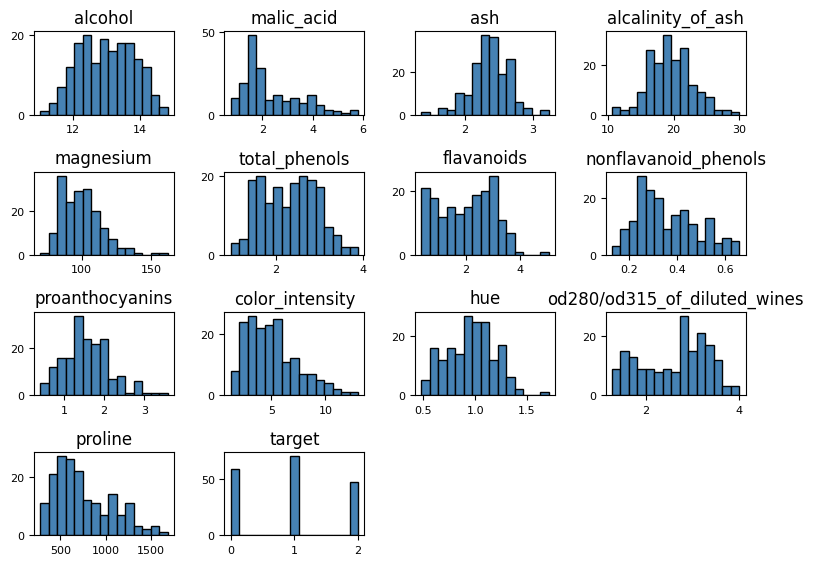

In [ ]:
df.hist(bins=15, color='steelblue', edgecolor='black', linewidth=1.0,
           xlabelsize=8, ylabelsize=8, grid=False)
plt.tight_layout(rect=(0, 0, 1.2, 1.2))

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=52, test_size=0.2)
model = MLPClassifier(random_state=42, max_iter=300, hidden_layer_sizes=param)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.42      1.00      0.59        11
           1       0.70      0.39      0.50        18
           2       0.00      0.00      0.00         7

    accuracy                           0.50        36
   macro avg       0.37      0.46      0.36        36
weighted avg       0.48      0.50      0.43        36



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
from functools import partial
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
smallest_model, min_neurons = find_min_neurons(X_train, X_test, y_train, y_test, min_score=0.95, score=partial(f1_score, average='weighted'))
y_pred = smallest_model.predict(X_test)
report = classification_report(y_test, y_pred)
print(report, "\n", min_neurons)

              precision    recall  f1-score   support

           0       0.81      0.93      0.87        14
           1       0.85      0.79      0.81        14
           2       0.71      0.62      0.67         8

    accuracy                           0.81        36
   macro avg       0.79      0.78      0.78        36
weighted avg       0.80      0.81      0.80        36
 
 28


In [ ]:
min_neurons

8

In [ ]:
from sklearn.model_selection import GridSearchCV
param_grid = {
    'mlpclassifier__hidden_layer_sizes': [
      (20),
      (10),
      (5),
      (20, 10),
      (10, 5),
      (10, 10),
      (20, 10, 5),
      (10, 10, 10),
      (10, 20, 10)
    ],
    'mlpclassifier__activation': ['relu', 'tanh', 'logistic'],
    'mlpclassifier__solver': ['adam'],
    'mlpclassifier__learning_rate': ['adaptive'],
    'mlpclassifier__max_iter': [200],
}
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('mlpclassifier', MLPClassifier())
])

grd_srch = GridSearchCV(pipeline, param_grid, cv=5, n_jobs=-1, scoring="f1_macro")

grd_srch.fit(X_train, y_train)
print(grd_srch.best_params_, "\n", grd_srch.best_score_)

{'mlpclassifier__activation': 'tanh', 'mlpclassifier__hidden_layer_sizes': (20, 10, 5), 'mlpclassifier__learning_rate': 'adaptive', 'mlpclassifier__max_iter': 200, 'mlpclassifier__solver': 'adam'} 
 0.9925696594427244


/usr/local/lib/python3.10/dist-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


In [ ]:
model

MLPClassifier(hidden_layer_sizes=(10, 20, 10), max_iter=300, random_state=42)

In [ ]:
y_pred = grd_srch.predict(X_test)
report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        11
           1       1.00      0.89      0.94        18
           2       0.78      1.00      0.88         7

    accuracy                           0.94        36
   macro avg       0.93      0.96      0.94        36
weighted avg       0.96      0.94      0.95        36



In [ ]:
confusion_matrix(y_test, y_pred)

array([[11,  0,  0],
       [ 0, 16,  2],
       [ 0,  0,  7]])

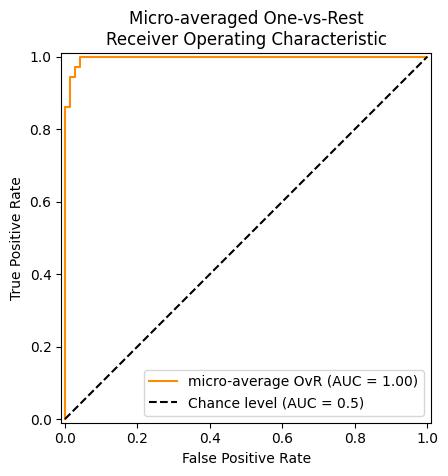

In [ ]:
from sklearn.preprocessing import LabelBinarizer

y_score = grd_srch.predict_proba(X_test)

label_binarizer = LabelBinarizer().fit(y_train)
y_onehot_test = label_binarizer.transform(y_test)
display = RocCurveDisplay.from_predictions(
    y_onehot_test.ravel(),
    y_score.ravel(),
    name="micro-average OvR",
    color="darkorange",
    plot_chance_level=True,
)
_ = display.ax_.set(
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
    title="Micro-averaged One-vs-Rest\nReceiver Operating Characteristic",
)

In [ ]:
from sklearn.multiclass import OneVsRestClassifier

classifier = OneVsRestClassifier(grd_srch)
classifier.fit(X_train, y_train)
y_score = classifier.predict_proba(X_test)

label_binarizer = LabelBinarizer().fit(y_train)
y_onehot_test = label_binarizer.transform(y_test)

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


In [ ]:
from sklearn.metrics import average_precision_score, precision_recall_curve

precision = dict()
recall = dict()
average_precision = dict()
for i in range(3):
    precision[i], recall[i], _ = precision_recall_curve(y_onehot_test[:, i], y_score[:, i])
    average_precision[i] = average_precision_score(y_onehot_test[:, i], y_score[:, i])

# A "micro-average": quantifying score on all classes jointly
precision["micro"], recall["micro"], _ = precision_recall_curve(
    y_onehot_test.ravel(), y_score.ravel()
)
average_precision["micro"] = average_precision_score(y_onehot_test, y_score, average="micro")

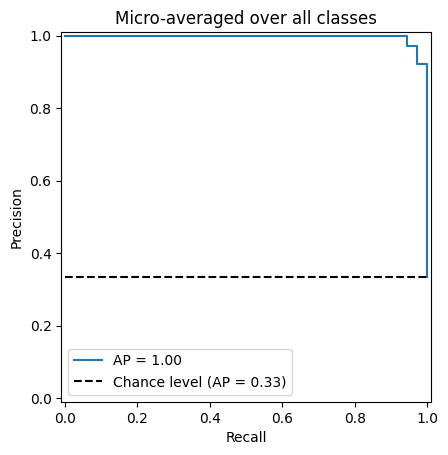

In [ ]:
from collections import Counter

display = PrecisionRecallDisplay(
    recall=recall["micro"],
    precision=precision["micro"],
    average_precision=average_precision["micro"],
    prevalence_pos_label=Counter(y_onehot_test.ravel())[1] / y_onehot_test.size,
)
display.plot(plot_chance_level=True)
_ = display.ax_.set_title("Micro-averaged over all classes")